<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Parallel CNN Testing Ground

Based on this [link from Kaggle](https://www.kaggle.com/vbookshelf/tuberculosis-tb-analyzer-web-app).

In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

The CNN will be trained using the CiFAR dataset which will predict images out of 10 classes and multiple trials of the experiment will be done.

In [2]:
import tensorflow as tf
import os
import zipfile
import cv2
import pandas as pd
import shutil
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.initializers import Constant, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.python.client import device_lib


Add Google Drive support to save the h5 file to Google Drive.

In [3]:
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/gdrive')
%cd '/content'
%ls '/gdrive/My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/content
'AP Physics 1 4'/                         'ML Club Functions.gdoc'
'Business Plan Summary.gdoc'              'Precalc Cheat Sheet.gdoc'
'Cell Biology 2019-2020'/                 'PupilPath Transcript.pdf'
'Colab Notebooks'/                         Science/
 English/                                 'Spanish '/
 History/                                  Transcript.pdf
'JE AP Language & Composition Period 2'/  'Universal Resume.docx'
'Language app Jonayet.gdoc'                xtra/
'ML Club'/


START

In [4]:
# DEBUG
print(tf.keras.__version__)
devices = device_lib.list_local_devices()
print(devices)

IMG_WIDTH = 96
IMG_HEIGHT = 96

2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9657020168828509725
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14844215498294508248
physical_device_desc: "device: XLA_CPU device"
]


Now, it is time to split the data into a training and testing directory in order to conviently grab them when training the network.

In [5]:
# The Image Data
target = pd.read_csv('target.csv')
target['slide'] = target['slide'].str.replace(".svs", ".png")

def open_slides(slide_dir="."):
  for slide in os.listdir(slide_dir):
    if slide.endswith(".zip"):
      print(slide)
      zip_file_i = zipfile.ZipFile(slide)
      zip_file_i.extractall(slide_dir)

print(target) 
x_train, x_test, y_train, y_test = train_test_split(target['slide'], target['target'], 
                                                    stratify=target['target'])

train_df = pd.DataFrame({'slide': x_train, 'target': y_train})
test_df = pd.DataFrame({'slide': x_test, 'target': y_test})

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

train_df

                       slide  target
0    HobI16-053768896760.png       1
1    HobI16-072823783181.png       1
2    HobI16-105105202254.png       0
3    HobI16-303757967057.png       0
4    HobI16-334188031493.png       0
..                       ...     ...
125  HobI18-711038761484.png       0
126  HobI18-767451561893.png       0
127  HobI18-789815111269.png       1
128  HobI18-796881418672.png       0
129  HobI18-987777882592.png       0

[130 rows x 2 columns]


,slide,target
0,HobI18-295854571047.png,0
1,HobI16-708082515907.png,0
2,HobI16-723628532151.png,0
3,HobI17-324909994030.png,0
4,HobI18-045092912528.png,0
...,...,...
92,HobI17-800973460562.png,1
93,HobI17-458471686651.png,0
94,HobI17-348600370849.png,0
95,HobI18-628416694544.png,0


Creating the folder tree.

In [6]:
open_slides()

cwd = os.getcwd()
train_dir = os.path.join(cwd, "train")
test_dir = os.path.join(cwd, "test")

if not os.path.exists(train_dir):
  os.mkdir(train_dir)

if not os.path.exists(test_dir):
  os.mkdir(test_dir)

benign_train = os.path.join(train_dir, "benign")
invasive_train = os.path.join(train_dir, "invasive")

benign_test = os.path.join(test_dir, "benign")
invasive_test = os.path.join(test_dir, "invasive")

if not os.path.exists(benign_train):
  os.mkdir(benign_train)

if not os.path.exists(benign_test):
  os.mkdir(benign_test)

if not os.path.exists(invasive_train):
  os.mkdir(invasive_train)

if not os.path.exists(invasive_test):
  os.mkdir(invasive_test)

target.set_index('slide', inplace=True)
target = target.replace({0: 'benign', 1: 'invasive'})

Output3.zip
Output1.zip
Output6.zip
Output5.zip
Output4.zip
Output2.zip
Output7.zip


In [0]:
def categorize_files(files, dst_dir=os.getcwd()):
  for img in files:
    print(img)
    category = target.loc[img, 'target']
    destination = os.path.join(dst_dir, category, img)
    for output_dir in os.listdir(cwd):
      if output_dir.startswith('Output') and os.path.isdir(output_dir):
        img_dir = os.path.join(output_dir, f"Output")
        imgs = os.listdir(img_dir)
        print(img_dir)
        if img in imgs:
          img_path = os.path.join(img_dir, img)
          pic_cv = cv2.imread(img_path)
          pic_cv = cv2.resize(pic_cv, (IMG_WIDTH, IMG_HEIGHT))
          cv2.imwrite(destination, pic_cv)

Now, plaicing the images into the folders so they are distributed correctly

In [8]:
train_list = list(train_df['slide'])
test_list = list(test_df['slide'])

categorize_files(train_list, train_dir)

categorize_files(test_list, test_dir)

HobI18-295854571047.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI16-708082515907.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI16-723628532151.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI17-324909994030.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI18-045092912528.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI17-519774790910.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI18-246204354838.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Output
Output2/Output
Output6/Output
HobI17-812250131208.png
Output1/Output
Output7/Output
Output4/Output
Output3/Output
Output5/Outpu

In [9]:
def check_photo_stats():
  print("Benign Photos in Train", end=": ")
  print(len(os.listdir(os.path.join(train_dir, "benign"))))

  print("Invasive Photos in Train", end=": ")
  print(len(os.listdir(os.path.join(train_dir, "invasive"))))

check_photo_stats()

Benign Photos in Train: 28955
Invasive Photos in Train: 10892


Now to add the augmented images to the training and testing folders in batches

In [0]:
''' This is the setup for the augmentation '''
classes = ["benign", "invasive"] # 0 is benign, 1 is cancer

batch_size = 32
NUM_IMAGES = 500

data_gen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=180,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    width_shift_range=.5,
    height_shift_range=.5,
    horizontal_flip=True,
    vertical_flip=True)

In [0]:
aug_dir = os.path.join(cwd, "aug_dir")
if not os.path.exists(aug_dir):
  os.mkdir(aug_dir)
  
img_aug_dir = os.path.join(aug_dir, "img_dir")

if not os.path.exists(img_aug_dir):
  os.mkdir(img_aug_dir)


In [0]:
''' The actual augmentation begins here with the variables above '''
def augmentation(category):
  class_dir = os.path.join(train_dir, category)
  for img in os.listdir(class_dir):
    curr_img = os.path.join(class_dir, img)
    dst_img = os.path.join(img_aug_dir, img)
    shutil.copyfile(curr_img, dst_img)

    augmented_gen = data_gen.flow_from_directory(aug_dir, save_to_dir=class_dir, 
                                                save_format = "png", target_size = (IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size = batch_size)  
    num_files = len(os.listdir(train_dir))
    BATCHES = int((np.ceil(NUM_IMAGES - num_files) / batch_size))
    # The above line calculates how much images to generate in order to get the amount needed.

    for i in range(BATCHES):
      next(augmented_gen) # GENERATE THE IMAGES
    # shutil.rmtree(aug_dir)

In [13]:
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=3) as executor:
  executor.submit(augmentation, 'benign')
  executor.submit(augmentation, 'invasive')

Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 112 images belonging to 1 classes.
Found 113 images belonging to 1 classes.
Found 114 images belonging to 1 classes.
Found 114 images belonging to 1 classes.
Found 114 images belonging to 1 classes.
Found 114 images belonging to 1 classes.
Found 115 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 116 images belonging to 1 classes.
Found 117 images belonging to 1 classes.
Found 117 images belonging to 1 classes.
Found 117 images belonging to 1 classes.
Found 117 images belonging to 1 classes.
Found 117 images belonging to 1 classes.
Found 118 images belonging to 1 classes.
Found 119 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 121 images belonging to 1 classes.
Found 122 images

KeyboardInterrupt: ignored

In [14]:
check_photo_stats()

Benign Photos in Train: 79900
Invasive Photos in Train: 61834


Now, this is a handy methods to view the image files. 

/content/train/benign/_245_2673503.png
/content/train/benign/_1_9567310.png
/content/train/benign/_35_3306326.png
/content/train/benign/_30_4221702.png
/content/train/benign/_33_4580373.png
/content/train/benign/_106_4034345.png
/content/train/benign/_10_8571787.png
/content/train/benign/_105_9979917.png
/content/train/benign/_60_2285443.png
/content/train/benign/_57_5042924.png
/content/train/benign/_245_2673503.png
/content/train/benign/_106_4034345.png
/content/train/benign/_57_5042924.png
/content/train/benign/_60_2285443.png
/content/train/benign/_1_9567310.png
/content/train/benign/_30_4221702.png
/content/train/benign/_33_4580373.png
/content/train/benign/_10_8571787.png
/content/train/benign/_35_3306326.png
/content/train/benign/_105_9979917.png
/content/train/benign/_10_8571787.png
/content/train/benign/_105_9979917.png
/content/train/benign/_35_3306326.png
/content/train/benign/_30_4221702.png
/content/train/benign/_60_2285443.png
/content/train/benign/_57_5042924.png
/conten

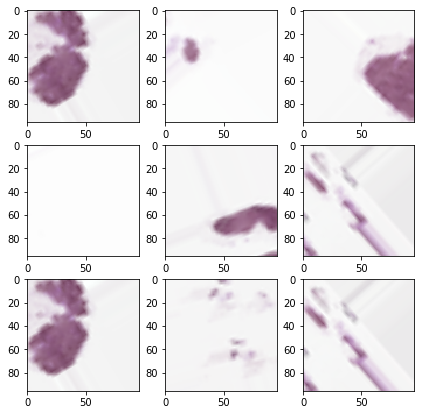

In [15]:
def visualize_imgs(image_dir):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    image_arr = os.listdir(image_dir)[:10]
    np.random.shuffle(image_arr)
    for img in image_arr:
      pic = cv2.imread(os.path.join(image_dir, img))
      print(os.path.join(image_dir, img))
      plt.imshow(pic)


visualize_imgs(benign_train)

# Deep Learning Time

First, I will setup the image data generators from the file and then I will set up the new model architecture. <br> <br>
Let's start with the image data generators, which will resize the images and feed them to the generator.

If you recall from earlier, the `train_list` and `test_list` variables were created above to represent how many items of each image are for training or testing.
```
train_list = list(train_df['slide'])
test_list = list(test_df['slide'])
```

In [16]:
num_train = len(train_list)
num_test = len(test_list)
train_batch = 32 
test_batch = 32

train_steps = np.ceil(num_train / train_batch)
test_steps = np.ceil(num_test / test_batch)
num_test

33

Found 328 images belonging to 1 classes.


In [17]:
rescale_gen = ImageDataGenerator(rescale=1.0/255)

train_gen = rescale_gen.flow_from_directory(train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                            batch_size=train_batch, 
                                            class_mode='categorical')
test_gen = rescale_gen.flow_from_directory(test_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                           batch_size=test_batch, 
                                           class_mode='categorical')

# The validation data set will not be shuffled. Perhaps, it is better to check?
validation_gen = rescale_gen.flow_from_directory(test_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                           batch_size=test_batch, 
                                           class_mode='categorical', shuffle=False)

Found 145843 images belonging to 2 classes.
Found 332 images belonging to 1 classes.
Found 79 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [0]:
filter1 = 16
filter2 = 32
filter3 = 64
max_norm_param = 3
dropout_rate = 0.4
dense_expansion = 256

def cancer_net(output_bias=None, reg_factor=.4):
    if output_bias is not None:
      output_bias = Constant(output_bias)
    
    
    model = tf.keras.models.Sequential(name="Breast Cancer Net")

    # Layer 1
    model.add(Conv2D(filter1, (3, 3), kernel_initializer=he_normal(), 
      input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), kernel_constraint=max_norm(max_norm_param), padding="same"))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filter1, (3, 1), padding="same", kernel_regularizer=l2(reg_factor)))
    model.add(Activation('elu'))
    model.add(Conv2D(filter1, (1, 3), padding="same", kernel_regularizer=l2(reg_factor)))
    model.add(Activation('elu'))
    
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_rate))

    # Layer 2
    model.add(Conv2D(filter2, (3, 3), padding="same", kernel_constraint=max_norm(max_norm_param)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filter2, (3, 1), padding="same", kernel_regularizer=l2(reg_factor)))
    model.add(Activation('elu'))
    model.add(Conv2D(filter2, (3, 1), padding="same", kernel_regularizer=l2(reg_factor)))
    model.add(Activation('elu'))

    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_rate))

    # Layer 3
    model.add(Conv2D(filter3, (3, 3), padding="same", kernel_constraint=max_norm(max_norm_param)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filter3, (3, 1), padding="same", kernel_regularizer=l2(reg_factor)))
    model.add(Activation('elu'))
    model.add(Conv2D(filter3, (1, 1), padding="same", kernel_regularizer=l2(reg_factor)))
    model.add(Activation('elu'))

    model.add(Dropout(dropout_rate))

    '''
    # Layer 4
    model.add(Conv2D(32, (3, 1), padding="same", kernel_constraint=max_norm(max_norm_param)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))

    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_rate))

    # Layer 5
    model.add(Conv2D(32, (1, 3), padding="same", kernel_constraint=max_norm(max_norm_param)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(dropout_rate))


    model.add(Conv2D(32, (3, 1), padding="same", kernel_constraint=max_norm_param(1)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    

    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_rate)) 
    ''' 

      #Layer 6
    model.add(Flatten())
    model.add(Dense(dense_expansion, kernel_constraint=max_norm(1, axis=0)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    # Layer 9
    model.add(Dense(2, bias_initializer=output_bias))
    model.add(Activation('sigmoid'))

    return model


Now the model is completed, I want to look at it and create model checkpoint paths to save it.

In [19]:
model_path = 'best-cancer-model.hdf5'

output_bias = np.log([(len(benign_train) + len(benign_test)) / 
                      (len(invasive_train) + len(invasive_test))])
print(output_bias)
model2 = cancer_net(output_bias)
model2.summary()

tf.keras.utils.plot_model(model2, 'model2-vis.png', show_shapes=True)
print()

Found 336 images belonging to 1 classes.
[-0.09309042]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Breast Cancer Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        784       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 1

# Running the Model
First, the GPU setup needs to be made and then the model can be evaluated using SGD.

In [20]:
# Are there any GPUs available to use?

gpus = [devices[i].device_type in devices for (i, device) in enumerate(devices) if "GPU" in devices[i].device_type]
isParallel = any(gpus)

print(gpus, isParallel)

[] False


In [21]:
# The starting learning rate of the model and SGD optimizer
learning_rate = 1e-03
EPOCHS = 300

optimizer = tf.keras.optimizers.SGD(lr=learning_rate, momentum=0.9, 
                                    nesterov = True)
optimizer

In [22]:
# Initialize the callbacks, the pleteau LR might be better than the LR scheduler I used before...
callbacks = []
callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1))
callbacks.append(ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, 
                                    verbose=1, save_freq='epoch'))
callbacks

In [0]:
if isParallel:
  print('GPUs parallelized!')
  model2 = tf.keras.utils.multi_gpu_model(model2, 2)
  model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=
                 [tf.keras.metrics.AUC(name="auc"), 'accuracy'])
  
  history = model2.fit_generator(train_gen,
                      steps_per_epoch=train_steps, epochs=EPOCHS,
                      validation_data=test_gen, validation_steps=test_steps, 
                      verbose=1, callbacks=callbacks)
else:
  print('CPU Compilation')

  model2.compile(optimizer=optimizer, loss="binary_crossentropy",
                metrics=[tf.keras.metrics.AUC(name="AUC"), 
                         'accuracy'])
  
  history = model2.fit_generator(train_gen, steps_per_epoch=train_steps,
                      validation_data=test_gen, validation_steps=test_steps,
                      epochs=EPOCHS, callbacks=callbacks)
  model.save(model_path)

CPU Compilation
Found 349 images belonging to 1 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
Found 350 images belonging to 1 classes.
2/4 [==============>...............] - ETA: 1s - loss: 87.5510 - AUC: 0.2965 - acc: 0.2812
Epoch 00001: val_acc improved from -inf to 0.28125, saving model to best-cancer-model.hdf5
Found 353 images belonging to 1 classes.
4/4 [==============================] - 14s 4s/step - loss: 88.8758 - AUC: 0.5019 - acc: 0.5156 - val_loss: 87.5510 - val_AUC: 0.2965 - val_acc: 0.2812
Epoch 2/300
3/4 [=====================>........] - ETA: 1s - loss: 86.9270 - AUC: 0.5702 - acc: 0.5573Found 354 images belonging to 1 classes.
Epoch 1/300
Found 355 images belonging to 1 classes.
2/4 [==============>...............] - ETA: 1s - loss: 84.7104 - AUC: 0.2889 - acc: 0.2812
Epoch 00002: val_acc did not improve from 0.28125
4/4 [==============================] - 9s 2s/step - loss: 86.5764 - AUC: 0.5521 - acc

# Evaluating the Model
Hope it is good... 😊

In [0]:
model2.load_weights(model_path)
val_auc, val_acc = model2.evaluate_generator(test_gen, steps=test_steps)
print(f"Validation AUC for the model is {val_auc}")
print(f"Validation ACCURACY for the model is {val_acc}")

In [0]:
def plot_curve(train_data, test_data, figname, title, ylabel):
  plt.clf()
  plt.plot(train_data)
  plt.plot(test_data)
  plt.xlabel('Epoch')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(figname)

In [0]:
plot_curve(history.history['acc'], 
           history.history['acc'], 'model2acc.png', 
           'Model Accuracy vs Epoch', 
          'Accuracy')
plot_curve(history.history['loss'], 
           history.history['val_loss'], 'model2loss.png',
           'Model Loss vs Epoch', 'Loss')